# Exploratory Data Analysis and Visualization
Anne Nguyen (23925126)

## Introduction

The data set we selected is about red and white variants of the Portuguese "Vinho Verde" wine and is found at the UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/186/wine+quality). The data set was created by Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis. This data was collected from red and white wine samples where physicochemical qualities were from objective tests such as a pH tests and the quality score was based on experts grading the wine quality between 0 (very bad) and 10 (very excellent). Some data such as grape type and wine brand have been omitted due to privacy and logistic issues.

There are 12 variables, 11 of which are are physicochemical qualities of the wine including fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol and 1 is an associated quality score. For the physicochemical qualities, the majority of the variables refer to the amount of the named variable in the wine while pH is a measure of the acidity/basicity of the wine, density is a measure of the concentration of the wine, fixed acidity is the amount of acids originating from the grapes, and volatile acidity refers to the amount of acid from microbial metabolism. All variables types are doubles. The data is separated into two files by wine colour. If the two data sets are combined, a factor variable called wine type would need to be added to identify whether the wine is red or white. There are a total of 6497 observations, 1599 of which are red and 4898 of which are white. There are no missing attributes.

I would like to predict how well a wine would be received (or how good it is) based on its physicochemical composition. The random variable of interest is the wine quality score. Exploratory analysis would include all physicochemical variables in the data set as explanatory variables and depending on whether there are high correlation, multicollinearity, or other reasons, a subset of those variables may be selected as the explanatory variables in the main analysis. Using the data, I would created a regression model to predict the quality score for new wines and determine which factors may be important for predicting wine quality. As the response variable is a subjective measure, there may be some biases and it may affect the correlation with the predictor variables. Clearly, this question is focused on prediction since I am using existing data to build a model to predict the response variable for new data.

## Exploratory Data Analysis

To begin the exploratory data analysis, the first step is to import the proper libraries for the analysis.

In [1]:
library(tidyverse)
library(ggplot2)
library(repr)
library(corrplot)
library(glmnet)
library(rsample)
library(mltools)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
corrplot 0.92 loaded

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8


Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na




The next step is to import the data and clean it. The data for red and white wine is read in and a column for the type of wine is added before combining the data sets into one data frame.

In [2]:
#Read the csv files
wine_red <- read_delim("https://raw.githubusercontent.com/a-nguyen-1/STAT301-Project/main/data/winequality-red.csv")
wine_white <- read_delim("https://raw.githubusercontent.com/a-nguyen-1/STAT301-Project/main/data/winequality-white.csv")

#Label wine type and combine into one data set
wine_red$type <- as.factor(rep("red",nrow(wine_red)))
wine_white$type <- as.factor(rep("white",nrow(wine_white)))
wine_data <- bind_rows(wine_red, wine_white)
head(wine_data)

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4898 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,red
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,red
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,red
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,red


Next, we examine some features of the data set following cleaning.

In [3]:
#Examine the data structure
str(wine_data)

#Examine the counts of observations, levels, missing values
data.frame(Total_observations = nrow(wine_data),
           Red_wine_observations = nrow(wine_data %>% filter(type == "red")),
           White_wine_observations = nrow(wine_data %>% filter(type == "white")),
           Missing_values = sum(is.na(wine_data)))

#Summary statistics of quantitative variables
wine_summary <- as.data.frame(sapply(wine_data[-13], summary))
wine_summary

spc_tbl_ [6,497 × 13] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ fixed acidity       : num [1:6497] 7.4 7.8 7.8 11.2 7.4 7.4 7.9 7.3 7.8 7.5 ...
 $ volatile acidity    : num [1:6497] 0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.5 ...
 $ citric acid         : num [1:6497] 0 0 0.04 0.56 0 0 0.06 0 0.02 0.36 ...
 $ residual sugar      : num [1:6497] 1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 6.1 ...
 $ chlorides           : num [1:6497] 0.076 0.098 0.092 0.075 0.076 0.075 0.069 0.065 0.073 0.071 ...
 $ free sulfur dioxide : num [1:6497] 11 25 15 17 11 13 15 15 9 17 ...
 $ total sulfur dioxide: num [1:6497] 34 67 54 60 34 40 59 21 18 102 ...
 $ density             : num [1:6497] 0.998 0.997 0.997 0.998 0.998 ...
 $ pH                  : num [1:6497] 3.51 3.2 3.26 3.16 3.51 3.51 3.3 3.39 3.36 3.35 ...
 $ sulphates           : num [1:6497] 0.56 0.68 0.65 0.58 0.56 0.56 0.46 0.47 0.57 0.8 ...
 $ alcohol             : num [1:6497] 9.4 9.8 9.8 9.8 9.4 9.4 9.4 10 9.5 10.5 ...
 $ quality             : num 

Total_observations,Red_wine_observations,White_wine_observations,Missing_values
<int>,<int>,<int>,<int>
6497,1599,4898,0


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min.,3.800000,0.080000,0.0000000,0.600000,0.00900000,1.00000,6.0000,0.9871100,2.720000,0.2200000,8.0000,3.000000
1st Qu.,6.400000,0.230000,0.2500000,1.800000,0.03800000,17.00000,77.0000,0.9923400,3.110000,0.4300000,9.5000,5.000000
Median,7.000000,0.290000,0.3100000,3.000000,0.04700000,29.00000,118.0000,0.9948900,3.210000,0.5100000,10.3000,6.000000
Mean,7.215307,0.339666,0.3186332,5.443235,0.05603386,30.52532,115.7446,0.9946966,3.218501,0.5312683,10.4918,5.818378
3rd Qu.,7.700000,0.400000,0.3900000,8.100000,0.06500000,41.00000,156.0000,0.9969900,3.320000,0.6000000,11.3000,6.000000
Max.,15.900000,1.580000,1.6600000,65.800000,0.61100000,289.00000,440.0000,1.0389800,4.010000,2.0000000,14.9000,9.000000


The data set has 6497 observations with 13 variables, 12 of which are numerical and 1 of which is categorical. Type is a factor with two levels, red and white, and there are 1599 red wine observations and 4898 white wine observations. It is confirmed that there are no missing values in the data set. The quantitative variables appear to be on different scales.

## Visualization

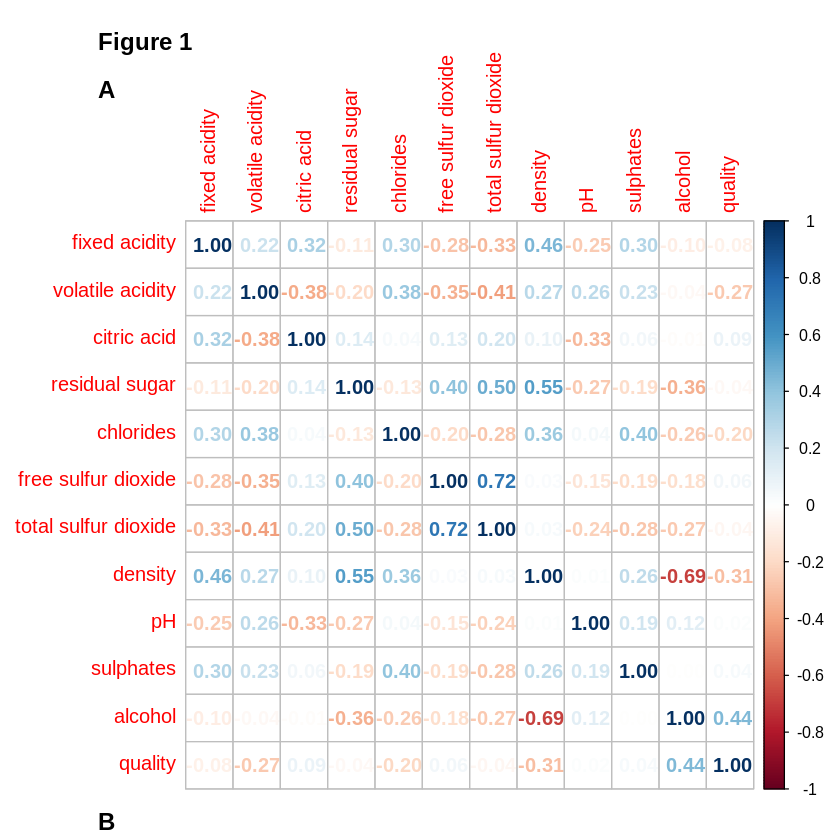

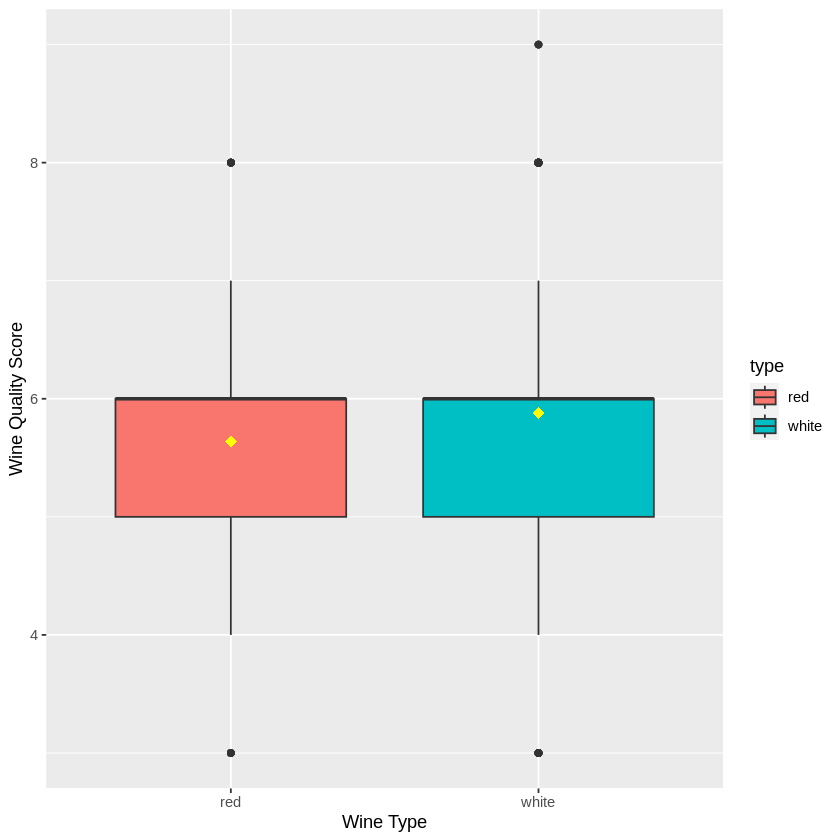

In [4]:
#Create correlation plot using quantitative variables
cor_mat <- cor(wine_data %>% select(-type))
cor_plot <- corrplot(cor_mat, method = 'number')
title("Figure 1", adj = 0, line = 2)
title("A", adj = 0, line = 0)

#Create boxplot of wine quality by wine type
wine_type_plot <- ggplot(data=wine_data, aes(x=type, y=quality, fill=type)) + geom_boxplot() +
    stat_summary(fun=mean, colour="yellow", geom="point", 
               shape=18, size=3, show.legend=FALSE) +
    xlab("Wine Type") +
    ylab("Wine Quality Score") +
    title("B", adj = 0, line = -30.5)
wine_type_plot

A box plot was created to examine categorical variables while the remaining quantitive variables were used to create a correlation matrix and the resulting correlation plot. These plots will aid us in exploring the relationship between the response variable and potential predictors and also in selecting the predictors for the model.

The correlation plot in Figure 1A shows the correlation between each of the quantitative variables. We see there is no strong correlation between the response variable, quality, and the potential predictor variables which is not surprising as quality is a subjective measure as described in the introduction. For the correlations between quality and the predictors, alcohol has the strongest correlation with a value of 0.44 while pH is the weakest with a value of 0.02. There appears to be multicollinearity between some potential predictor variables such as total sulfur dioxide and free sulfur dioxide with a correlation of 0.72. The multicollinearity of the predictors would need to be taken into consideration when selecting the predictor variables for the model. 

Figure 1B shows a boxplot of wine quality score by wine type where the yellow diamond indicates the mean quality score for each wine type. Though the mean for white wine appears to be higher, the distribution for the two wine types appear to be quite similar so there may not be a need to distinguish between the two types in the model.

## Methods and Plan

Based on the plots above and discussion with other group members, only the red wine data set will be used and therefore, there is no longer a need to use a categorical variable for the wine type. Removal of the type variable will allow stepwise or regularized methods using `regsubset` or `glmnet` to be used because use with categorical variables is not implemented in those packages. Though quality score is not a continuous variable, it will be treated as such when creating the model due to the complexity of the regression model when quality is instead considered as a class. The fitted values ending in 0.5 will be round up to the nearest integer. Below 0.5, values will be rounded down to the nearest integer.

As there appears to be multicollinearity between variables, regularized methods such as elastic net or ridge regression would be suitable for fitting a model to predict the wine quality score over ordinary least squares. Multicollinearity can introduces instability in the model by having high variance in the estimates of the model coefficients. These regression methods deal with the issue by introducing some bias to reduce the variance and as a result, the overall mean squared error (MSE). In this bias-variance trade-off, the lowest overall MSE would be at a penalty parameter value (lambda) that optimizes this trade-off. Since the aim of the research question is prediction, it is preferable to aim for lower MSE for better prediction performance. Based on the reasons above, ridge regression will be used to fit the model to predict wine quality. Additional reasons for why ridge is chosen over other regularized methods is that elastic net has not been covered much in the course (such as selection of alpha in `glmnet`) and lasso regression may be less reliable in multicollinearity as it tends to select one variable at random from a group of correlated variables. Assumptions about ridge regression have not been covered however a limitation of ridge regression is that it does not do variable selection and may keep irrelevant variables. As well, by introducing bias, there is a loss of interpretability of the coefficients as the effect of each predictor.

In regards to the analysis, first, the data will be split into training and testing subset with 75% of the data in the training set and 25% in the testing set. A seed using the number 301 will be used for reproducible results. A design matrix will be created using all the predictors and scaling will be handled in the `glmnet` functions (scaling is needed as regularized methods depend on the size of the coefficients). 5-fold cross validation using the same seed with `cv.glmnet` will be used to determine the optimal value of lambda for ridge regression. The model fitted using the optimal lambda will then be used to predict on the testing set and the prediction error will be examined for model performance. Lastly, the model will be used the determine the predicted quality score of a new observation.

## Implementation of a proposed model

In [5]:
set.seed(301)

wine_red <- wine_red %>% select(-type)
wine_split <- initial_split(wine_red, prop = 0.75, strata = quality)
training_wine <- training(wine_split)
testing_wine <- testing(wine_split)
head(training_wine)

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5
7.9,0.60,0.06,1.6,0.069,15,59,0.9964,3.30,0.46,9.4,5
7.5,0.50,0.36,6.1,0.071,17,102,0.9978,3.35,0.80,10.5,5
6.7,0.58,0.08,1.8,0.097,15,65,0.9959,3.28,0.54,9.2,5
7.5,0.50,0.36,6.1,0.071,17,102,0.9978,3.35,0.80,10.5,5


In [6]:
set.seed(301)

quality <- training_wine$quality
design_matrix <- model.matrix(~ ., data = training_wine %>% select(-quality))
cv_model <- cv.glmnet(x = design_matrix, y = quality, alpha = 0, nfolds = 5)
cv_model


Call:  cv.glmnet(x = design_matrix, y = quality, nfolds = 5, alpha = 0) 

Measure: Mean-Squared Error 

    Lambda Index Measure      SE Nonzero
min 0.0374   100  0.4320 0.02205      11
1se 0.5557    71  0.4537 0.02265      11

In [7]:
min_lam <- cv_model$lambda.min
ridge_model <- glmnet(x = design_matrix, y = quality, alpha = 0, lambda = min_lam)
ridge_model$beta

12 x 1 sparse Matrix of class "dgCMatrix"
                                  s0
(Intercept)              .          
`fixed acidity`          0.034555199
`volatile acidity`      -1.024534615
`citric acid`           -0.196813805
`residual sugar`         0.021415492
chlorides               -1.874141412
`free sulfur dioxide`    0.003649884
`total sulfur dioxide`  -0.002775829
density                -26.187323014
pH                      -0.407583404
sulphates                1.018539957
alcohol                  0.253739331

In [8]:
true_quality <- tibble(true_quality = testing_wine$quality)
test_design_matrix <- model.matrix(~ ., data = testing_wine %>% select(-quality))
ridge_pred <- as.data.frame(round(predict(ridge_model, test_design_matrix)))
ridge_pred <- tibble(pred = ridge_pred$s0)
ridge_rmse <- rmse(true_quality,ridge_pred)
ridge_mr <- mean(true_quality != ridge_pred)

ols <- as.data.frame(round(predict(lm(quality ~ ., training_wine), testing_wine)))
ols <- tibble(ols = ols[,1])
ols_rmse <- rmse(true_quality,ols)
ols_mr <- mean(true_quality != ols)

results <- tibble(Model = c("Ridge Regression", "OLS Regression"), RMSE = c(ridge_rmse, ols_rmse),
                 Misclassification_Rate = c(ridge_mr, ols_mr))
print("Table 1")
results

[1] "Table 1"


Model,RMSE,Misclassification_Rate
<chr>,<dbl>,<dbl>
Ridge Regression,13.82027,0.3790524
OLS Regression,14.07125,0.3840399


The results in Table 1 are the RMSE and misclassification rates from the ridge and OLS regression models on the testing set for the red wine data. The RMSE and misclassification error rate are lower in the ridge regression model as expected as the method handles some of variance due the multicollinearity of the predictors by introducing bias into the model however the classification error rate is still quite high at 37.9%. As well, RMSE does not seem to be a suitable measure of error as the average deviation between predicted and actual values being 13.8 does not make sense as quality scores range from 0 to 10. Due to the above reasons, ridge regression and treating quality as a continuous variable with rounding may not be approprate methods to use for the prediction of quality score and other multi-class classification methods such as KNN, random forest, or boosting may be more appropriate.